# Putting it all together: easily beautifying emotions in faces...


The code in this script detects faces and their emotions in an arbitrary image. It then adds the style transfer to the area of the detected face according to its emotion.

This notebook combines the best models from the notebooks YOLO_350_pics.ipynb and emotion_detection_VGG16.ipynb, and adds the style transfer, which was previously prepared in a septarate notebook.

## Part I - Face detection and emotion prediction

In [1]:
#!pip install numpy
!pip install ultralytics
!pip install tensorflow_hub

In [2]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from ultralytics import YOLO
from PIL import Image
import PIL
import cv2

import tensorflow as tf
import tensorflow_hub as hub
import os
# load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'


In [3]:
# run locally
# load your favourite image

#image = 'IMG_20230908_145817.jpg'
#path = 'C:/Users/eli/Nextcloud/HSLU/Vorlesungen/Computer_Vision_CVI03/Project/Our_Pictures/'
#img = path+image

In [4]:
# run on colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# run on colab
# load your favourite image

image = 'IMG_20230908_145811.jpg'
path = '../content/drive/MyDrive/ComputerVision/Our Pictures/'
img = path+image

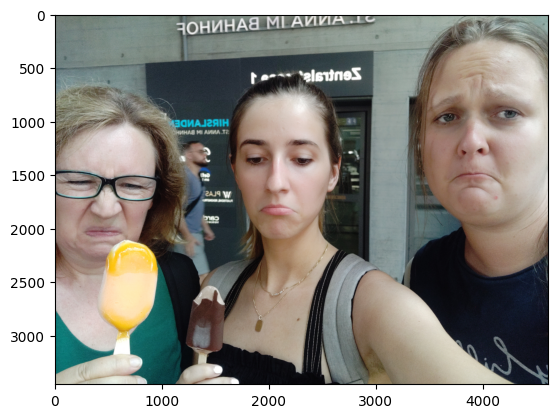

In [48]:
image = Image.open(img)
image = np.array(image)
image[:, :, [0, 2]] = image[:, :, [2, 0]]
#cv2_imshow(image)

# show the image with matplotlib, as cv_2.imshow() doesn't work for me...
# need to 're-arrange' channels, as OpenCV uses BGR array instead of RGB (-> convert BGR to RGB)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.imshow(image)
plt.show()

In [49]:
# load pretrained model for object detection

#model_1=torch.load("../content/drive/MyDrive/ComputerVision/Models/object_detection.pt")
#model_object_detection = torch.load('C:/Users/eli/Nextcloud/HSLU/Vorlesungen/Computer_Vision_CVI03/Project/model_saves/object_detection.pt')
model_object_detection = torch.load('../content/drive/MyDrive/ComputerVision/Models/object_detection.pt')

In [50]:
# detect faces

results=model_object_detection.predict(source=img,save=True,classes=0)


image 1/1 /content/../content/drive/MyDrive/ComputerVision/Our Pictures/IMG_20230908_145811.jpg: 480x640 3 facess, 29.0ms
Speed: 3.1ms preprocess, 29.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict6


In [51]:
# load pretrained model for emotion detection

#clf=tf.keras.models.load_model("../content/drive/MyDrive/ComputerVision/Models/CNN.h5")
#clf=tf.keras.models.load_model('C:/Users/eli/Nextcloud/HSLU/Vorlesungen/Computer_Vision_CVI03/Project/model_saves/3rd_run_VGG16_model.h5')
#trying another mode (less overfitting)
#clf=tf.keras.models.load_model('C:/Users/eli/Nextcloud/HSLU/Vorlesungen/Computer_Vision_CVI03/Project/model_saves/3rd_run_VGG16_model.h5')
clf=tf.keras.models.load_model('/content/drive/MyDrive/ComputerVision/Models/CNN_regularized.h5')

1/1 [==============================] - 0s 52ms/step


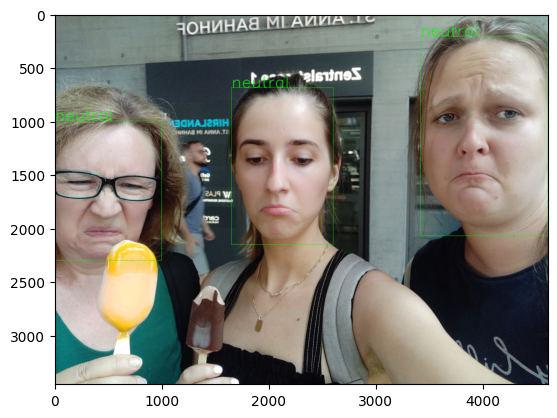

datatype of image: uint8
[['neutral', 0, 996, 998, 2300], ['neutral', 3416, 4607, 207, 2071], ['neutral', 1649, 2600, 687, 2153]]


In [52]:
# predict emotion
remapping = {0:'angry',
             1:'disgust',
             2:'fear',
             3:'happy',
             4:'neutral',
             5:'sad',
             6:'surprise'}

face_list = []

for box,conf in zip(results[0].boxes.xywh,results[0].boxes.conf):
    x, y, width, height = box  # Unpack the coordinates

    # Convert float values to integers
    x, y, width, height = int(x), int(y), int(width), int(height)

    cv2.rectangle(image, (int(x - 0.5*width), int(y - 0.5*height)), (int(x + 0.5*width), int(y + 0.5*height)), (0, 255, 0), 2)  # Here, (0, 255, 0) is the color (green), and 2 is the thickness of the bounding box

    x1 = int(x - width / 2)
    y1 = int(y - height / 2)
    x2 = int(x + width / 2)
    y2 = int(y + height / 2)

# Crop the region of interest from the image
    cropped_image = image[y1:y2, x1:x2]
    cropped_image=cv2.resize(cropped_image, (48,48))
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    image_arr=np.array(gray_image)
    image_arr=np.expand_dims(image_arr, axis=-1)
    image_arr=np.expand_dims(image_arr, axis=0)
    label=pd.DataFrame(np.argmax(clf.predict(image_arr),axis=1))[0].map(remapping)[0]
    cv2.putText(image, label, (int(x- 0.5*width), int(y- 0.5*height) ), cv2.FONT_HERSHEY_SIMPLEX, 5.0, (0, 255, 0), 5)

    face_list.append([label, x1, x2, y1, y2])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
#cv2_imshow(image)
print('datatype of image:', image.dtype)
print(face_list)

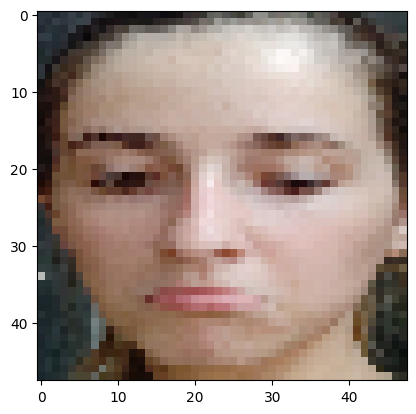

datatype of cropped image: uint8
label: neutral


In [53]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.show()
print('datatype of cropped image:', cropped_image.dtype)
print('label:', label)

# Part II - Beautify emotions in faces

## Selection of style according to the emotion

In [54]:
# Collection of paintings

# Wassily Kandinsky     kandinsky_swinging.jpg
# Frida Kahlo           kahlo.jpg
# Claude Monet          monet_irises.jpg, monet_water_lilies.jpg
# Pablo Picasso
# Edvard Munch          munch_schrei.jpg
# Vincent van Gogh      vangogh_night_vision.jpg
# Gustav Klimt          klimt_adele_bloch.jpg
# Roy Lichtenstein      lichtenstein_girl.jpg

In [55]:
# style selection according to emotion (label)

style_selection = {'angry':'vangogh_night_vision.jpg',
                   'disgust':'kandinsky_swinging.jpg',
                   'fear':'munch_schrei.jpg',
                   'happy':'klimt_adele_bloch.jpg',
                   'neutral':'kahlo.jpg',
                   #'neutral':'klimt_adele_bloch.jpg',
                   'sad':'lichtenstein_girl.jpg',
                   'surprise':'monet_irises.jpg' }
#remapping = {0:'angry',
#             1:'disgust',
#             2:'fear',
#             3:'happy',
#             4:'neutral',
#             5:'sad',
#             6:'surprise'}

### Define functions

In [56]:
# not used here
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [57]:
# not used here
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [58]:
# plot the image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [59]:
# converts style image to tensor
def load_style_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [60]:
# converts content image to tensor
def load_content_img(content_image):
  max_dim = 512
  img = np.asarray(content_image)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [61]:
# turns a 'normal' image into an image with the painters' style
def style_face(content_tensor, style_tensor):
    stylized_image = hub_model(tf.constant(content_tensor), tf.constant(style_tensor))[0]
    tensor_to_image(stylized_image)
    return stylized_image

In [62]:
# replace a face by the artistic augmented painter-style picture
def replace_face(image, stylized_image, x1, x2, y1, y2):
    # turn into numpy-array and get rid of first dimension
    artistic_image = np.squeeze(stylized_image.numpy(), axis=0)
    # resize to same size as the original cropped picture
    artistic_image = cv2.resize(artistic_image, (x2 - x1, y2 - y1))
    ###print('size of artistic image:', artistic_image.shape, 'size should be in x,y:', x2 - x1, y2 - y1)
    ###plt.imshow(artistic_image)
    ###plt.show()

    # convert the float32-format back to uint8-format (...otherhwise it will display as black...)
    artistic_image = (artistic_image * 255).astype(np.uint8)
    artistic_image = cv2.cvtColor(artistic_image, cv2.COLOR_BGR2RGB)
    # replace the cropped part with the artistic image
    image[y1:y2, x1:x2] = artistic_image

    return(image)

    # show image
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.show()

### Artistic Faces

In [64]:
# define path to paintings:
#art_path = 'C:/Users/eli/Nextcloud/HSLU/Vorlesungen/Computer_Vision_CVI03/Project/graphs/'
art_path = '../content/drive/MyDrive/ComputerVision/Style_Pictures/'

In [23]:
# faces_list
#[['neutral', 1726, 2648, 725, 2165],
# ['sad', 56, 1161, 1030, 2405],
# ['neutral', 3518, 4597, 94, 1940]]

In [65]:
#get model for style transfer
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [25]:
#print(faces_list)
#['sad', 56, 1161, 1030, 2405]
#style_selection['sad']
#style_selection[faces_list[1][0]]

In [ ]:
# get all style transfers for the chosen image

['neutral', 0, 996, 998, 2300]
kahlo.jpg
['neutral', 3416, 4607, 207, 2071]
kahlo.jpg
['neutral', 1649, 2600, 687, 2153]
kahlo.jpg


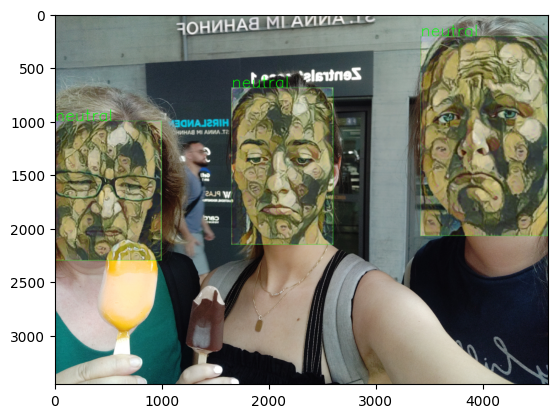

In [66]:
for a_face in face_list:
    print(a_face)
    # get coordinates
    x1 = a_face[1]
    x2 = a_face[2]
    y1 = a_face[3]
    y2 = a_face[4]
    # get style
    artist_image = style_selection[a_face[0]]
    print(artist_image)
    style_path = art_path+artist_image
    # get images
    style_image = cv2.imread(style_path)
    content_image = image[y1:y2, x1:x2]
    # transform to correct format (here BGR format and not RGB as in input)
    content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
    style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
    # define tensors
    style_tensor = load_style_img(style_path)
    content_tensor = load_content_img(content_image)
    # the face gets a re-styling...
    stylized_image = style_face(content_tensor, style_tensor)
    #replace the original face with stylized_image)
    image = replace_face(image, stylized_image, x1, x2, y1, y2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
